In [60]:
import glob, string
import pandas as pd
import os
import re
import nltk
import numpy as np
import gensim
import spacy
from string import punctuation
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize,RegexpTokenizer
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz


In [3]:
path = "/Users/arjunbabu/Advanced Text analytics/Project/20news-bydate/*/*/[0-9]*"

In [4]:
files = glob.glob(path)

In [5]:
import codecs
from tqdm import tqdm

def BuildDataframe(file_list):
    train=[]
    test=[]
    mode="r"
    encoding="utf-8"
    e_option="ignore"
    for file in tqdm(file_list):
        text = codecs.open(file, mode,encoding, e_option).read() 
        if("20news-bydate-test" in file):
            test.append((text,file.split("/")[-2]))
        else:
            train.append((text,file.split("/")[-2]))
    return pd.DataFrame(train,columns=['text','newsgroup']),pd.DataFrame(test,columns=['text','newsgroup'])

In [6]:
train_news,test_news=BuildDataframe(files)

100%|██████████| 18846/18846 [00:04<00:00, 4122.51it/s]


In [7]:
type(train_news)

pandas.core.frame.DataFrame

In [8]:
train_news.groupby('newsgroup').text.nunique()

newsgroup
alt.atheism                 480
comp.graphics               584
comp.os.ms-windows.misc     591
comp.sys.ibm.pc.hardware    590
comp.sys.mac.hardware       578
comp.windows.x              593
misc.forsale                585
rec.autos                   594
rec.motorcycles             598
rec.sport.baseball          597
rec.sport.hockey            600
sci.crypt                   595
sci.electronics             591
sci.med                     594
sci.space                   593
soc.religion.christian      599
talk.politics.guns          546
talk.politics.mideast       564
talk.politics.misc          465
talk.religion.misc          377
Name: text, dtype: int64

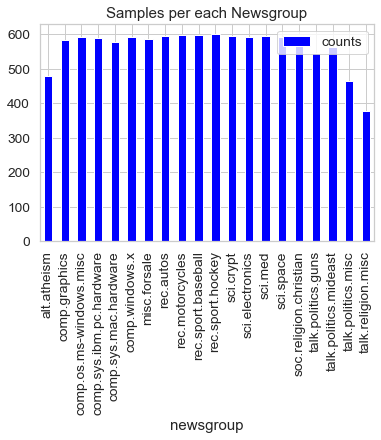

In [72]:
train_news.groupby('newsgroup').size().reset_index(name="counts").plot.bar(x='newsgroup',title="Samples per each Newsgroup",color='blue')

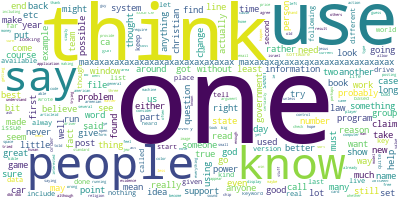

In [89]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(train_news['text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

# <b>DATA PRE-PROCESSING</b>

In [10]:
#Cleaning the header, from , subject summery etc.
def clean_header(text):
    text = re.sub(r'(From:\s+[^\n]+\n)', '', text)
    text = re.sub(r'(Subject:[^\n]+\n)', '', text)
    text = re.sub(r'(([\sA-Za-z0-9\-]+)?[A|a]rchive-name:[^\n]+\n)', '', text)
    text = re.sub(r'(Last-modified:[^\n]+\n)', '', text)
    text = re.sub(r'(Version:[^\n]+\n)', '', text)
    text = re.sub(r'(Expires:[^\n]+\n)', '', text)
    text = re.sub(r'(Summary:[^\n]+\n)', '', text)
    text = re.sub(r'(Organization:[^\n]+\n)', '', text)
    text = re.sub(r'(Lines:[^\n]+\n)', '', text)
    text = re.sub(r'(article)', '', text)
    text = re.sub(r'(writes)', '', text)  
    text = re.sub(r'(NNTP-Posting-Host)', '', text) 
    text = re.sub(r'(Nntp-Posting-Host)', '', text)
    text = re.sub(r'(In-Reply-To)', '', text)
    text = re.sub(r'(zzzzzzt)', '', text)
    text = re.sub(r'(maxaxaxaxaxaxaxaxaxaxaxaxaxax)', '', text)
    text = re.sub(r'(Distribution:[^\n]+\n)', '', text)
    text = re.sub(r'(X-Newsreader:)', '', text)
    text = re.sub(r'(TIN)', '', text)
    text = re.sub(r'(version 1.1 PL6)', '', text)
    return text


In [11]:
train_news['text'] = train_news.text.apply(clean_header)

In [12]:
train_news

,text,newsgroup
0,": hernlem@chess.ncsu.edu's message of Wed, 14 ...",talk.politics.mideast
1,"\nab4z@Virginia.EDU (""Andi Beyer"") :\n\n> Firs...",talk.politics.mideast
2,: evenwood\n\n\n Andrew Varvel :\n>\n>\n> Serd...,talk.politics.mideast
3,: composer.think.com\n\nIn <1993Apr15.204930....,talk.politics.mideast
4,: rize.ece.orst.edu\n\n> Problem 1\n> \n> My f...,talk.politics.mideast
...,...,...
11309,\nI'm greatly in need of Jurgen\nMoltmann's bo...,talk.religion.misc
11310,[]\n\n (U28698@uicvm.uic.edu) wrote:\n: Mari...,talk.religion.misc
11311,: rac3.wam.umd.edu\n\nIn <1qknu0INNbhv@shelle...,talk.religion.misc
11312,"\nIn <C51puA.K2u@mailer.cc.fsu.edu>, dlecoint...",talk.religion.misc


In [13]:
#Remove HTML

#Finding if there are any html tags in the text data

train_news.text.str.findall('<script[\s\S]*?/script>[\s\S]*?|href=[\s\S]*?>[\s\S]*?|<br />|<ul[\s\S]*?/ul>[\s\S]*?|<li[\s\S]*?/li>[\s\S]*?|<style type[\s\S]*?/style>[\s\S]*?|<object[\s\S]*?/object>[\s\S]*?|(<a href[\s\S]*?>[\s\S]*?)|(\b(http|https):\/\/.*[^ alt]\b)|</ul>|</li>|<br/>|<!--[\s\S]*?-->[\s\S]*?|<div style[\s\S]*?>[\s\S]*?|<img[\s\S]*?>[\s\S]*?|<div id[\s\S]*?>[\s\S]*?|<div class[\s\S]*?>[\s\S]*?|</object>|<embed[\s\S]*?/>[\s\S]*?|<param[\s\S]*?/>[\s\S]*?|<noscript>[\s\S]*?</noscript>[\s\S]*?|<link rel[\s\S]*?>[\s\S]*?|<p style="text-align: center;">|<iframe[\s\S]*?</iframe>[\s\S]*?')

0        []
1        []
2        []
3        []
4        []
         ..
11309    []
11310    []
11311    []
11312    []
11313    []
Name: text, Length: 11314, dtype: object

From the above output, we can see there no html tags in the data. We have checked for all the possible tags.

In [14]:
#Remove EmailID

#Finding emailids in the data
train_news.text.str.findall('[A-Za-z0-9_-]*@[A-Za-z0-9._-]*\s?')

0        [hernlem@chess.ncsu.edu, 21737@ncsu.edu, hernl...
1                                     [ab4z@Virginia.EDU ]
2                               [Gannon@newcastle.ac.uk\n]
3        [9517@thunder.mcrcim.mcgill.edu, hasan@McRCIM....
4                                                       []
                               ...                        
11309                   [susan_soric@upubs.uchicago.edu\n]
11310    [U28698@uicvm.uic.edu, acb@yoyo.cc.monash.edu....
11311    [1qknu0INNbhv@shelley.u.washington.edu, siefer...
11312    [K2u@mailer.cc.fsu.edu, dlecoint@garnet.acns.f...
11313    [24320@mnemosyne.cs.du.edu, kditto@nyx.cs.du.e...
Name: text, Length: 11314, dtype: object

In [15]:
train_news.text.replace('[A-Za-z0-9_-]*@[A-Za-z0-9._-]*\s?','',regex=True, inplace = True)

In [16]:
# Verifying if the email ids are removed or not
train_news.text.str.findall('[A-Za-z0-9_-]*@[A-Za-z0-9._-]*\s?')

0        []
1        []
2        []
3        []
4        []
         ..
11309    []
11310    []
11311    []
11312    []
11313    []
Name: text, Length: 11314, dtype: object

From the above output, we can see there no emails in the data

In [17]:
#Formatting text using Regex

#1 Expanding Contractions

m=[ "\'m", "\'s" , "\'ve" , "n\'t", "\'re", "\'d", "\'ll"]
n=[" am"," is"," have" ," not" ," are" ," had" ,"will" ]

In [18]:
for i in m:
    for k in n:
        train_news.text.replace(i,k,regex=True, inplace = True)

In [19]:
#2 Delete double space, and sequences of "-,*,^,."
    
train_news.text.replace('\s{2,}|\?{2,}|\!{2,}|#{2,}|={2,}|-{2,}|_{2,}|\.{2,}|\*{2,}|\^{2,}','',regex=True, inplace = True)

In [20]:
#3 Separating symbols from words

#l=['\(','\/','\)','\?','\¿', '\]','\[','\}','\{','<','"','>',',','!','\.','\:','\-']
#z=[' ( ', ' / ', ' ) ',' ? ',' ¿ ',' ] ',' [ ',' } ',' { ',' < ',' " ',' > ',' , ',' ! ',' . ',' : ',' - ']

In [21]:
#for i in l:
#    for k in z:
#        train_news.text.replace(i,k,regex=True, inplace = True)

In [22]:
#Remove punctuations

def punct(text):
    try:
        text=text.str.replace('[^\w\s]','')
    except:
        pass
    return text

In [23]:
train_news['text'] = train_news.apply(punct)

In [24]:
#Making text in lowercase

train_news['text']=train_news['text'].map(lambda x: x.lower() if type(x)==str else x)

In [25]:
#Removing numbers
train_news.text.replace('\d+','',regex=True, inplace = True)

In [26]:
train_news

,text,newsgroup
0,am message of wed apr gmtinapr brad hernlem...,talk.politics.mideast
1,\nandi beyer first of all i never said the ho...,talk.politics.mideast
2,evenwoodandrew varvel \n\n\n serdar argicaka ...,talk.politics.mideast
3,composerthinkcominapr\n inapr alan stein \n ...,talk.politics.mideast
4,rizeeceorstedu problem \n my father told me t...,talk.politics.mideast
...,...,...
11309,\ni am greatly in need of jurgen\nmoltmann am ...,talk.religion.misc
11310,wrote\n marian catholic high school outside o...,talk.religion.misc
11311,racwamumdeduin eric sieferman \nin paul harve...,talk.religion.misc
11312,\nincpua darius_lecointe \n david r sacco dsav...,talk.religion.misc


In [27]:
########################Sentiment data generation#################################

In [28]:
#Copying Data frame to new DF and aggrigating all the texts in a folder to its newsgroup for sentiment analysis.

train_news_sentiment = train_news.copy()

In [29]:
train_news_sentiment=train_news_sentiment.groupby(['newsgroup'], as_index = False).agg({'text': ' '.join})

In [30]:
train_news_sentiment

,newsgroup,text
0,alt.atheism,hrusnews\n \nxmailer psilinkdos datefri apr ...
1,comp.graphics,porthoustonpubippsinetjoe green \n anyone kn...
2,comp.os.ms-windows.misc,silverucsindianaeduinapr tom haapanen has any...
3,comp.sys.ibm.pc.hardware,slcinscwruedugoshi think i just installed a v...
4,comp.sys.mac.hardware,\nin apr fred walsteijn i am seen the followin...
5,comp.windows.x,\nhello everybodyi hope that i insert the righ...
6,misc.forsale,texas instruments ti procalc new in box wmanua...
7,rec.autos,tamutstamueduanother user recently requested ...
8,rec.motorcycles,\ninapr \nhas anyone ever heard of a rider giv...
9,rec.sport.baseball,articleid pospl\n bstudentcwrueduinapr kevin m...


In [31]:
##############################Back to data processing for Topic modeling#######################

In [32]:
#Removing Stop Words
stop_words = stopwords.words('english')

train_news['text'] = train_news['text'].str.split() \
    .apply(lambda x: ' '.join([word for word in x if word not in stop_words]))

In [33]:
train_news

,text,newsgroup
0,message wed apr gmtinapr brad hernlem lebanese...,talk.politics.mideast
1,andi beyer first never said holocaust said hol...,talk.politics.mideast
2,evenwoodandrew varvel serdar argicaka serdar a...,talk.politics.mideast
3,composerthinkcominapr inapr alan stein guess h...,talk.politics.mideast
4,rizeeceorstedu problem father told following s...,talk.politics.mideast
...,...,...
11309,greatly need jurgen moltmann book god creation...,talk.religion.misc
11310,wrote marian catholic high school outside chic...,talk.religion.misc
11311,racwamumdeduin eric sieferman paul harvey inbs...,talk.religion.misc
11312,incpua darius_lecointe david r sacco dsav snid...,talk.religion.misc


In [34]:
########################################Tokenize and Lemmatize##########################################

In [35]:
#Tokenization

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

train_news_data = list(sent_to_words(train_news.text))


In [37]:
#pip install -U spacy && python -m spacy download en

In [38]:
#spacy.cli.download("en")

In [39]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sentnc in texts:
        doc = nlp(" ".join(sentnc)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

nlp = spacy.load('en', disable=['parser', 'ner'])

#lemmatization keeping only Noun, Adj, Verb, Adverb
Train_news_lemmatized = lemmatization(train_news_data, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(Train_news_lemmatized[:2])

['message resistance force detonate bomb israeli lebanese territory day ago soldier kill andtwo wound retaliation israeli israelibacke force wound civilian bombard several lebanese village ironically justifie occupation claim isnecessary prevent bombardment israeli brave man lebanese resistance son place underlining occupation draw attention policy reckless disregard people murder bradly overjoyed hear death jewish death feel sadness hope soon stop apparently view point acceptable people', 'first never say say ignorant know people maybe include first sign argument state areaif know itif shut upsimple thati think suffer justify crime commit israeli government attempt call civil liberterian antisemetic suffer perish sufferedsecond namecalling direct generalyour namedroppe fancy sound political term yet attempt cite order obfuscate glare unpreparedness minor']


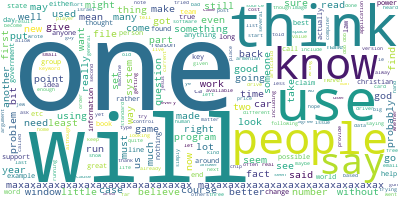

In [42]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(train_news['text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [43]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum requiredd occurences of a word 
                             stop_words='english',             # re doing to make sure remove stop words
                             lowercase=False,                  # as already lowercase
                             token_pattern='[a-zA-Z0-9]{4,}'  # num chars > 4
                                         
                            )


# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(Train_news_lemmatized)

In [44]:
#Topic Modeling

import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()



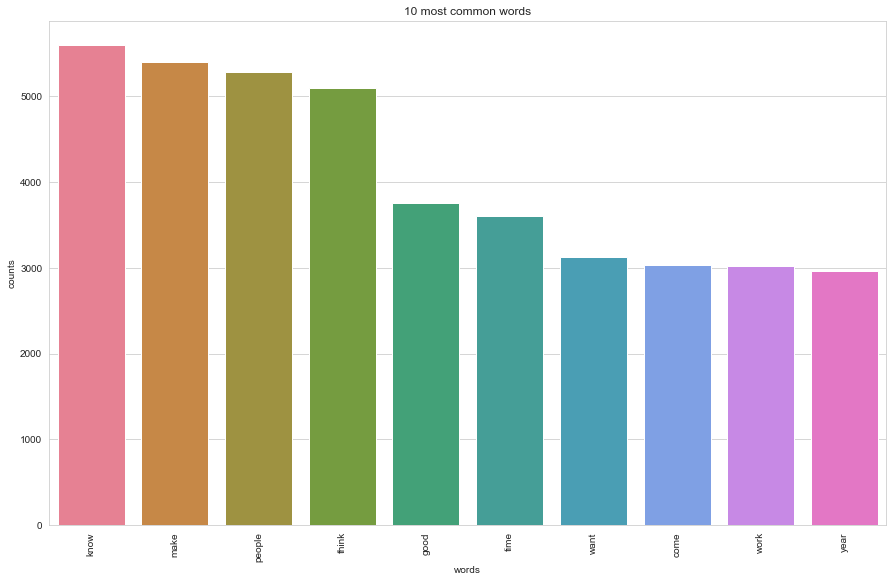

In [45]:
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [46]:

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA


In [47]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [48]:
# Build LDA Model
lda = LDA (                           n_components=20,           # Number of topics
                                      max_iter=20,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
ldafit = lda.fit_transform(count_data)

print(lda)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=20,
                          mean_change_tol=0.001, n_components=20, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [49]:
# Print the topics found by the LDA_post model
print("Topics found via LDA_post model:")
print_topics(lda, count_vectorizer, 20)

Topics found via LDA_post model:

Topic #0:
drive hard bike problem opinion work cause know mouse rider effect wave blood soon weight head right express type help

Topic #1:
turkish period armenian lunar close power today russian pass year serve history interpret second work long percent single genocide proceed

Topic #2:
question answer exist mean thing true human rule think resource problem right make reason sense read time person case follow

Topic #3:
government public right state private protect security service federal case privacy clipper legal court secret secure provide enforcement citizen issue

Topic #4:
water cable medical research doctor health ship earth patient shuttle block center energy volume facility observation year report large plant

Topic #5:
food woman goal child eternal study pain brain edge parent mother verse human liberty body thinking animal life family death

Topic #6:
book post write read know reference posting message issue group view church list theory 

In [50]:
#pip install -U pyLDAvis
#import pyLDAvis.gensim
import pyLDAvis.sklearn

/Users/arjunbabu/opt/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


In [51]:
pyLDAvis.enable_notebook()
Dashboard = pyLDAvis.sklearn.prepare(lda, count_data, count_vectorizer, mds='tsne')
Dashboard

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
14      -6.453542  -37.114674       1        1  14.930514
19      33.150570  -52.099636       2        1  12.494018
8      -61.099754   25.241901       3        1  10.152293
11      36.676186   20.397781       4        1   7.761351
13      24.313581  103.897964       5        1   7.052984
6       95.414078   64.189171       6        1   5.619718
3       33.223270  -14.653499       7        1   4.681353
9       64.102615   91.971886       8        1   4.540788
7        1.275630    2.317141       9        1   4.339185
2       63.706417   43.021019      10        1   3.977987
18     -19.553638  104.181274      11        1   3.420426
4       10.335268   38.320980      12        1   3.287161
17     -37.403503  -10.774470      13        1   3.250965
12      74.955879  -32.625843      14        1   2.791440
1      -43.729797   66.497055      15        1   2.281136
0       35.360912   64.459229      16        1   2.268695
16      68.358665    4.325609      17        1   2.190213
10     -23.185633   30.749012      18        1   2.032806
5       -2.966179   69.432686      19        1   1.880296
15     102.808311   19.681366      20        1   1.046671, topic_info=            Term         Freq        Total Category  logprob  loglift
1964        file  2415.000000  2415.000000  Default  30.0000  30.0000
3881     program  1762.000000  1762.000000  Default  29.0000  29.0000
1571       drive  1782.000000  1782.000000  Default  28.0000  28.0000
2192        good  3754.000000  3754.000000  Default  27.0000  27.0000
3695        play  1188.000000  1188.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
4102      reduce    84.671003   286.223963  Topic20  -4.3674   3.3416
1843  experience    66.552500   621.333849  Topic20  -4.6082   2.3257
3510        page    59.664971   337.675066  Topic20  -4.7174   2.8262
3777    practice    57.482106   320.354827  Topic20  -4.7547   2.8416
3131    minority    48.911647   153.228933  Topic20  -4.9162   3.4176

[1279 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
8        10  0.989392  abortion
10        6  0.982309   absence
12        2  0.995526  absolute
20        9  0.979484  academic
24        1  0.700286    accept
...     ...       ...       ...
5695      5  0.305918     young
5695      8  0.063607     young
5695     12  0.027260     young
5695     18  0.163560     young
5695     19  0.251398     young

[3152 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 20, 9, 12, 14, 7, 4, 10, 8, 3, 19, 5, 18, 13, 2, 1, 17, 11, 6, 16])

In [56]:
#GridSearch the best LDA model
#Most important tuning parameter for LDA models is n_components (number of topics) and learning_decay (which controls the learning rate)

# Define Search Param
search_params = {'n_components': [10, 20, 25], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LDA()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(count_data)

/Users/arjunbabu/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                   

In [58]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(count_data))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -1721684.494982038
Model Perplexity:  1592.5716723847383


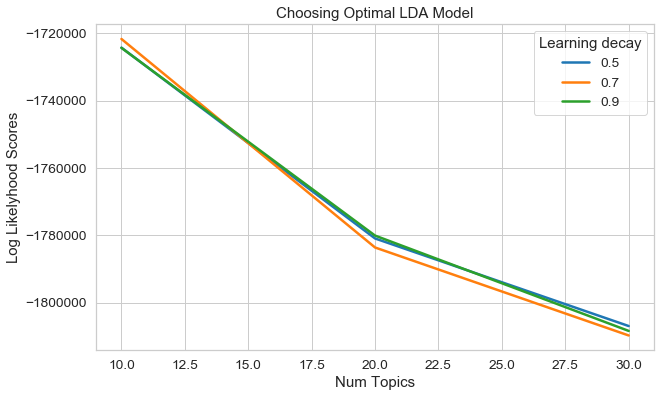

In [61]:
#Compare LDA Model Performance Scores

# Get Log Likelyhoods from Grid Search Output
n_topics = [10,20,30]
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]


# Show graph
plt.figure(figsize=(10, 6))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [62]:
#Dominant topic in each document?

# Create Document - Topic Matrix
lda_output = best_lda_model.transform(count_data)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(train_news.text))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.000000,0.000000,0.000000,0.000000,0.000000,0.360000,0.140000,0.000000,0.480000,0.000000,8
Doc1,0.000000,0.000000,0.000000,0.000000,0.000000,0.650000,0.000000,0.000000,0.330000,0.000000,5
Doc2,0.010000,0.160000,0.010000,0.010000,0.010000,0.510000,0.010000,0.260000,0.010000,0.010000,5
Doc3,0.260000,0.000000,0.230000,0.000000,0.000000,0.000000,0.250000,0.250000,0.000000,0.000000,0
Doc4,0.670000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.310000,0.000000,0
Doc5,0.000000,0.000000,0.250000,0.000000,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,5
Doc6,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.320000,0.580000,0.010000,8
Doc7,0.070000,0.000000,0.000000,0.000000,0.000000,0.340000,0.000000,0.000000,0.580000,0.000000,8
Doc8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.940000,0.010000,8
Doc9,0.020000,0.000000,0.000000,0.000000,0.000000,0.920000,0.050000,0.000000,0.000000,0.000000,5


In [63]:
# Review topics distribution across documents

df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,1,2421
1,4,1736
2,9,1629
3,2,1536
4,5,827
5,8,786
6,3,679
7,7,628
8,0,542
9,6,530


In [65]:
pyLDAvis.enable_notebook()
Dashboard = pyLDAvis.sklearn.prepare(best_lda_model, count_data, count_vectorizer, mds='tsne')
Dashboard

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      317.898163    2.494982       1        1  17.139363
9       86.074562   72.676720       2        1  13.542807
1      170.994263 -152.466003       3        1  11.497019
4     -209.019226 -218.755447       4        1  11.256756
5     -284.941620    5.453078       5        1  10.947361
8     -137.980270  160.331573       6        1   8.724649
3       18.692268  305.379700       7        1   7.854238
6      -53.087349  -64.788139       8        1   7.003594
0      241.948135  226.702347       9        1   6.197108
7       14.239793 -297.454956      10        1   5.837106, topic_info=        Term         Freq        Total Category  logprob  loglift
1964    file  2393.000000  2393.000000  Default  30.0000  30.0000
1571   drive  1791.000000  1791.000000  Default  29.0000  29.0000
5603  window  1548.000000  1548.000000  Default  28.0000  28.0000
5034    team  1129.000000  1129.000000  Default  27.0000  27.0000
2124    game  1111.000000  1111.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
529     body   120.855265   517.186951  Topic10  -5.7302   1.3871
5132   thing   154.507452  2783.242208  Topic10  -5.4846  -0.0502
3710   point   141.137985  1974.748078  Topic10  -5.5751   0.2025
2340    high   129.810423  1202.256079  Topic10  -5.6587   0.6151
5642    work   135.083550  2999.012056  Topic10  -5.6189  -0.2592

[789 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
12        1  0.887860  absolute
12        2  0.009060  absolute
12        4  0.013590  absolute
12        5  0.067948  absolute
12        6  0.009060  absolute
...     ...       ...       ...
5683      8  0.113193      year
5683      9  0.101224      year
5683     10  0.077969      year
5688     10  0.992621     yeast
5698      5  0.964567   zionism

[2579 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 10, 2, 5, 6, 9, 4, 7, 1, 8])

In [70]:
# Saving pyLDAvis to HTML file

from pyLDAvis import sklearn as sklearn_lda
import pickle
LDAvis_data_filepath = os.path.join('/Users/arjunbabu/Advanced Text analytics/Project/Python_codes/ldavis_prepared_5ldavis'+str(10))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
   LDAvis_prepared = Dashboard
   with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared,f)

In [71]:
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath,'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, '/Users/arjunbabu/Advanced Text analytics/Project/Python_codes/ldavis_prepared_5ldavis'+ str(10) +'.html')

# Sentiment Analysis

In [354]:
#################### Sentiment of each word within the top 10 topics topic###################

allwordsintopic=[]
wordsint=[]
for w in range(0,10):
    all_topic = best_lda_model.components_[w]
    top_words_topic = all_topic.argsort()[-20:]
    wordsint=["Topic %d" %(w+1)]
    for i in top_words_topic:
        wordsint.append(count_vectorizer.get_feature_names()[i])     
    allwordsintopic.append(wordsint)

In [355]:
allwordsintopic_dataframe =pd.DataFrame(allwordsintopic)
allwordsintopic_dataframe

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,Topic 1,unit,genocide,flight,today,earth,lunar,close,shuttle,satellite,...,long,time,mission,orbit,work,year,armenian,launch,turkish,space
1,Topic 2,sell,thing,fast,email,disk,hard,speed,think,price,...,want,driver,look,problem,need,good,work,know,card,drive
2,Topic 3,religion,evidence,life,true,fact,point,reason,claim,come,...,word,mean,question,good,thing,believe,know,make,people,think
3,Topic 4,access,protect,secure,technology,number,security,need,clipper,privacy,...,post,public,know,message,phone,make,information,government,encryption,chip
4,Topic 5,ride,right,bike,start,score,point,really,season,come,...,know,time,player,make,think,play,game,year,team,good
5,Topic 6,time,death,person,firearm,know,thing,mean,want,israeli,...,case,kill,crime,weapon,think,make,government,state,right,people
6,Topic 7,rate,know,large,fund,wire,spend,support,service,government,...,people,want,ground,think,year,work,cost,program,money,make
7,Topic 8,health,think,case,disease,effect,make,patient,year,food,...,insurance,good,time,study,people,medical,drug,doctor,cause,know
8,Topic 9,right,live,year,thing,leave,look,hear,woman,time,...,child,make,kill,happen,want,think,tell,come,know,people
9,Topic 10,software,version,display,need,information,list,look,work,send,...,application,know,problem,write,include,available,image,program,window,file


In [356]:
allwordsintopic_clean=[]
for i in range(0,10):
    allwordsintopic_clean.append(allwordsintopic[i][1:])

In [357]:
#pip install afinn
from afinn import Afinn

afinn = Afinn()
score_affin=[]
wordscore=[]

for i in range(0,10):
    wordscore=["Topic %d" %(i+1)]
    for n in allwordsintopic_clean[i]:
        wordscore.append({n:afinn.score(n)})
    score_affin.append(wordscore)

In [358]:
affin_score_dataframe =pd.DataFrame(score_affin)
affin_score_dataframe

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,Topic 1,{'unit': 0.0},{'genocide': 0.0},{'flight': 0.0},{'today': 0.0},{'earth': 0.0},{'lunar': 0.0},{'close': 0.0},{'shuttle': 0.0},{'satellite': 0.0},...,{'long': 0.0},{'time': 0.0},{'mission': 0.0},{'orbit': 0.0},{'work': 0.0},{'year': 0.0},{'armenian': 0.0},{'launch': 0.0},{'turkish': 0.0},{'space': 0.0}
1,Topic 2,{'sell': 0.0},{'thing': 0.0},{'fast': 0.0},{'email': 0.0},{'disk': 0.0},{'hard': -1.0},{'speed': 0.0},{'think': 0.0},{'price': 0.0},...,{'want': 1.0},{'driver': 0.0},{'look': 0.0},{'problem': -2.0},{'need': 0.0},{'good': 3.0},{'work': 0.0},{'know': 0.0},{'card': 0.0},{'drive': 0.0}
2,Topic 3,{'religion': 0.0},{'evidence': 0.0},{'life': 0.0},{'true': 2.0},{'fact': 0.0},{'point': 0.0},{'reason': 0.0},{'claim': 0.0},{'come': 0.0},...,{'word': 0.0},{'mean': 0.0},{'question': 0.0},{'good': 3.0},{'thing': 0.0},{'believe': 0.0},{'know': 0.0},{'make': 0.0},{'people': 0.0},{'think': 0.0}
3,Topic 4,{'access': 0.0},{'protect': 1.0},{'secure': 2.0},{'technology': 0.0},{'number': 0.0},{'security': 0.0},{'need': 0.0},{'clipper': 0.0},{'privacy': 0.0},...,{'post': 0.0},{'public': 0.0},{'know': 0.0},{'message': 0.0},{'phone': 0.0},{'make': 0.0},{'information': 0.0},{'government': 0.0},{'encryption': 0.0},{'chip': 0.0}
4,Topic 5,{'ride': 0.0},{'right': 0.0},{'bike': 0.0},{'start': 0.0},{'score': 0.0},{'point': 0.0},{'really': 0.0},{'season': 0.0},{'come': 0.0},...,{'know': 0.0},{'time': 0.0},{'player': 0.0},{'make': 0.0},{'think': 0.0},{'play': 0.0},{'game': 0.0},{'year': 0.0},{'team': 0.0},{'good': 3.0}
5,Topic 6,{'time': 0.0},{'death': -2.0},{'person': 0.0},{'firearm': 0.0},{'know': 0.0},{'thing': 0.0},{'mean': 0.0},{'want': 1.0},{'israeli': 0.0},...,{'case': 0.0},{'kill': -3.0},{'crime': -3.0},{'weapon': 0.0},{'think': 0.0},{'make': 0.0},{'government': 0.0},{'state': 0.0},{'right': 0.0},{'people': 0.0}
6,Topic 7,{'rate': 0.0},{'know': 0.0},{'large': 0.0},{'fund': 0.0},{'wire': 0.0},{'spend': 0.0},{'support': 2.0},{'service': 0.0},{'government': 0.0},...,{'people': 0.0},{'want': 1.0},{'ground': 0.0},{'think': 0.0},{'year': 0.0},{'work': 0.0},{'cost': 0.0},{'program': 0.0},{'money': 0.0},{'make': 0.0}
7,Topic 8,{'health': 0.0},{'think': 0.0},{'case': 0.0},{'disease': -1.0},{'effect': 0.0},{'make': 0.0},{'patient': 0.0},{'year': 0.0},{'food': 0.0},...,{'insurance': 0.0},{'good': 3.0},{'time': 0.0},{'study': 0.0},{'people': 0.0},{'medical': 0.0},{'drug': 0.0},{'doctor': 0.0},{'cause': 0.0},{'know': 0.0}
8,Topic 9,{'right': 0.0},{'live': 0.0},{'year': 0.0},{'thing': 0.0},{'leave': -1.0},{'look': 0.0},{'hear': 0.0},{'woman': 0.0},{'time': 0.0},...,{'child': 0.0},{'make': 0.0},{'kill': -3.0},{'happen': 0.0},{'want': 1.0},{'think': 0.0},{'tell': 0.0},{'come': 0.0},{'know': 0.0},{'people': 0.0}
9,Topic 10,{'software': 0.0},{'version': 0.0},{'display': 0.0},{'need': 0.0},{'information': 0.0},{'list': 0.0},{'look': 0.0},{'work': 0.0},{'send': 0.0},...,{'application': 0.0},{'know': 0.0},{'problem': -2.0},{'write': 0.0},{'include': 0.0},{'available': 0.0},{'image': 0.0},{'program': 0.0},{'window': 0.0},{'file': 0.0}


In [364]:
#Aggrigate Sentiment score of top 20 words in top 10 topics.


afinn = Afinn()
agg_score_affin=[]
agg_wordscore=0

for i in range(0,10):
    #print ("Topic %d" %(i+1))
    agg_wordscore=0
    for n in allwordsintopic_clean[i]:
        agg_wordscore=+(afinn.score(n))
    agg_score_affin.append({("Topic %d" %(i+1)),agg_wordscore})

In [365]:
agg_score_affin

[{0.0, 'Topic 1'},
 {0.0, 'Topic 2'},
 {0.0, 'Topic 3'},
 {0.0, 'Topic 4'},
 {3.0, 'Topic 5'},
 {0.0, 'Topic 6'},
 {0.0, 'Topic 7'},
 {0.0, 'Topic 8'},
 {0.0, 'Topic 9'},
 {0.0, 'Topic 10'}]

In [ ]:
#Lets perform Sentiment Analysis using Vader on each documents(entire newsgroups' text)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [ ]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{} Newsgroup's overall sentiment = {}".format(train_news_sentiment.newsgroup[i],str(score)))

In [ ]:
#To find the overall sentiment of each news group texts.
for i in range(0,train_news_sentiment.text.count()):
    sentiment_analyzer_scores(train_news_sentiment.text[i])

In [ ]:
###################################End########################################